In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [2]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter

from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

import cx_spiking.optimisation.metric as metric
import cx_spiking.optimisation.ng_optimiser as ng_optimiser

### Load route and generate spike versions of headings and optic flow

In [3]:
route_file = 'data/route.npz'
T_outbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings, digitized = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)

Load route from data/route.npz
data/route.npz exists - not overwriting it


### Rate based CX

In [4]:
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=0,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

### Poisson groups

In [5]:
start_scope()

time_step = 20 # ms

This is the spiking input

In [6]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')

Model neuron group that requires optimisation.

In [7]:
# Neuron group
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, neuron_params, name='TL2')

# Add monitors
STM_TL2, SPM_TL2 = nc.add_monitors(G_TL2, name='TL2')

# Connect heading to TL2
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, 
                                      params=synapses_params, on_pre=synapses_eqs_ex)

This is the **target** for the optimisation.

In [8]:
TL2_spike_rates = 90 # Hz

# Scale spike rates from rate-based CX in the right range
# transpose since log is neuron_index*time_step but we want the opposite
TL2_stimulus = TimedArray(TL2_spike_rates*cx_log.tl2.T*Hz, dt=1.*time_step*ms)
P_TL2 = PoissonGroup(N_TL2, rates='TL2_stimulus(t,i)')
SPM_TL2_IDEAL = SpikeMonitor(P_TL2, name='TL2_target')

Store network 

In [9]:
store()

In [10]:
def run_simulation(tauE_, tauI_, wE_, wI_, G, S, target_spike_monitor,
                   time, dt_, delta, rate_correction): 
    restore() 
    
    # set the parameters 
    #tauE = tauE * ms
    #tauI = tauI * ms
    G.set_states({'tauE' : tauE_*ms,
                  'tauI' : tauI_*ms})
    print(f'taueE: {tauE_} - tauI {tauI_}')
    #print(G.get_states())

    #wE = wE * nS
    #wI = wI * nS
    S.set_states({'wE' : wE_*nS,
                  'wI' : wI_*nS})
    print(f'wE: {wE_} - wI {wI_}')
    #print(S.get_states())

    _, model_spike_monitor = nc.add_monitors(G)
    
    run(time)
    
    gf = metric.compute_gamma_factor(model_spike_monitor, target_spike_monitor, time, 
                                     dt_=dt_, delta=delta, rate_correction=rate_correction)

    return gf

In [11]:
# Values to optimise
bounds = [[0,5],     # tauE [ms]
          [0,5],     # tauI [ms]
          [200,1000], # wE   [nS]
          [200,1000]] # wI   [nS]


# Other fixed arguments to optimisation function
delta = 1*ms
rate_correction = True

args = [
        G_TL2,                   # neuron group to optimise
        S_P_HEADING_TL2,         # synapses to optimise
        SPM_TL2_IDEAL,           # target spike monitor
        T_outbound*time_step*ms, # simulation time
        defaultclock.dt,         # simulation time step
        delta,                   # time window for gamma factor
        rate_correction          # apply rate correction to gamma factor
       ]

In [12]:
# Set instruments
instruments = ng_optimiser.set_instrumentation(bounds, args)
optim = ng_optimiser.set_optimiser(instruments, method='DE', budget=10)

WARNING    /Users/ff/.pyenv/versions/3.8.2/envs/py_msc/lib/python3.8/site-packages/nevergrad/optimization/differentialevolution.py:216: InefficientSettingsWarning: DE algorithms are inefficient with budget < 60
  warnings.warn("DE algorithms are inefficient with budget < 60", base.InefficientSettingsWarning)
 [py.warnings]
  warnings.warn("DE algorithms are inefficient with budget < 60", base.InefficientSettingsWarning)



[Array((1,), [ArctanBound(a_max=[5], a_min=[0], name=At([0],[5]), shape=(1,))]), Array((1,), [ArctanBound(a_max=[5], a_min=[0], name=At([0],[5]), shape=(1,))]), Array((1,), [ArctanBound(a_max=[1000], a_min=[200], name=At([200],[1000]), shape=(1,))]), Array((1,), [ArctanBound(a_max=[1000], a_min=[200], name=At([200],[1000]), shape=(1,))]), NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='TL2'), Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses'), <SpikeMonitor, recording from TL2_target>, 30. * second, 100. * usecond, 1. * msecond, True]


In [13]:
optim_min, recommendation = ng_optimiser.run_optimiser(optim, run_simulation, verbosity=2)

Launching 1 jobs with new suggestions
taueE: 1.153780672083985 - tauI 3.5036196943235094
wE: 779.0082278754546 - wI 536.2608943290998


WARNING    "EL" is an internal variable of group "TL2", but also exists in the run namespace with the value -52. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Updating fitness with value 3.9576015218758083
9 remaining budget and 0 running jobs
Current pessimistic best is: Point<x: [-1.12886023  0.73002314  0.84736731 -0.25566458], mean: 3.9576015218758083, count: 1>
Launching 1 jobs with new suggestions
taueE: 1.8260672301071734 - tauI 3.779044488894405
wE: 502.4058293336452 - wI 403.128092441469
Updating fitness with value 3.4835254898090247
8 remaining budget and 0 running jobs
Current pessimistic best is: Point<x: [-0.45071029  1.03718103 -0.40318775 -0.97572894], mean: 3.4835254898090247, count: 1>
Launching 1 jobs with new suggestions
taueE: 4.418369098333974 - tauI 3.2602307731060964
wE: 515.4293053147014 - wI 532.0568845781564
Updating fitness with value 14.106599726800884
7 remaining budget and 0 running jobs
Current pessimistic best is: Point<x: [-0.45071029  1.03718103 -0.40318775 -0.97572894], mean: 3.4835254898090247, count: 1>
Launching 1 jobs with new suggestions
taueE: 1.0953598449006108 - tauI 4.385998719237904
wE: 461.161507

In [14]:
candidate = optim_min.provide_recommendation()

In [15]:
print(candidate.args)

(1.0953598449006108, 4.385998719237904, 461.16150774969765, 724.6371008695247, NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='TL2'), Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses'), <SpikeMonitor, recording from TL2_target>, 30. * second, 100. * usecond, 1. * msecond, True)


### Test

In [16]:
start_scope()

time_step = 20 # ms

In [17]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')

In [19]:
params_TL2 = neuron_params

params_TL2['tauE'] = candidate.args[0] * ms
params_TL2['tauI'] = candidate.args[1] * ms

print(params_TL2)

synapses_TL2 = synapses_params
synapses_TL2['wE'] = candidate.args[2] * nS
synapses_TL2['wI'] = candidate.args[3] * nS

print(synapses_TL2)

{'EL': [-52. * mvolt], 'Vm': [-52. * mvolt], 'EE': [0. * volt], 'EI': [-80. * mvolt], 'gL': [1. * usiemens], 'gE': '(randn() * 1.5 + 4) * 10.*nS', 'gI': '(randn() * 12 + 20) * 10.*nS', 'tauE': 1.09535984 * msecond, 'tauI': 4.38599872 * msecond}
{'wE': 0.46116151 * usiemens, 'wI': 0.7246371 * usiemens}


In [20]:
# Neuron group
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, params_TL2, name='TL2_test')

# Add monitors
STM_TL2, SPM_TL2 = nc.add_monitors(G_TL2, name='TL2_test')

# Connect heading to TL2
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, params=synapses_TL2, model=synapses_model, on_pre=synapses_eqs_ex)

In [21]:
%%time
run(T_outbound*time_step*ms)

WARNING    "EL" is an internal variable of group "TL2_test", but also exists in the run namespace with the value -52. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


CPU times: user 35.5 s, sys: 610 ms, total: 36.1 s
Wall time: 47.7 s


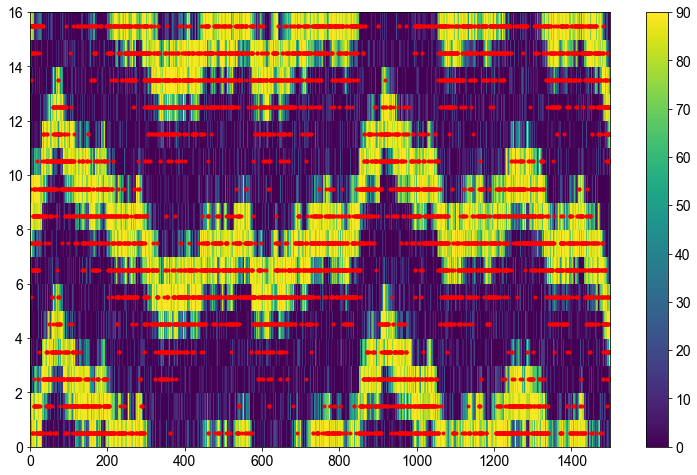

In [22]:
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tl2, TL2_spike_rates, SPM_TL2, time_step, figsize=(13,8))

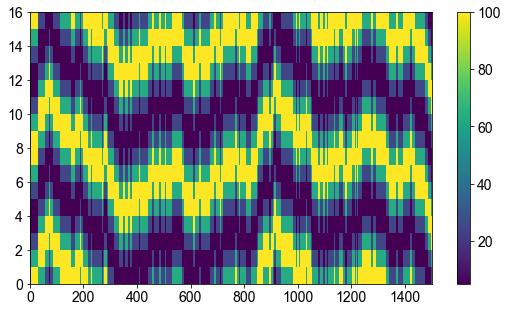

In [23]:
plt.figure(figsize=(9,5))
plt.pcolormesh(headings.T)
plt.colorbar()
plt.show()

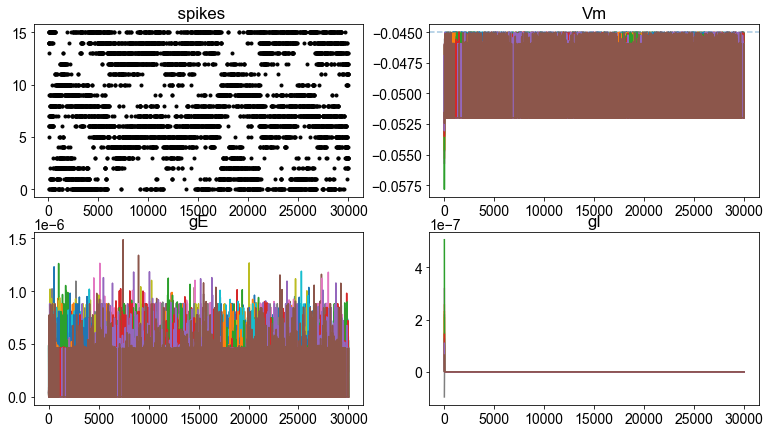

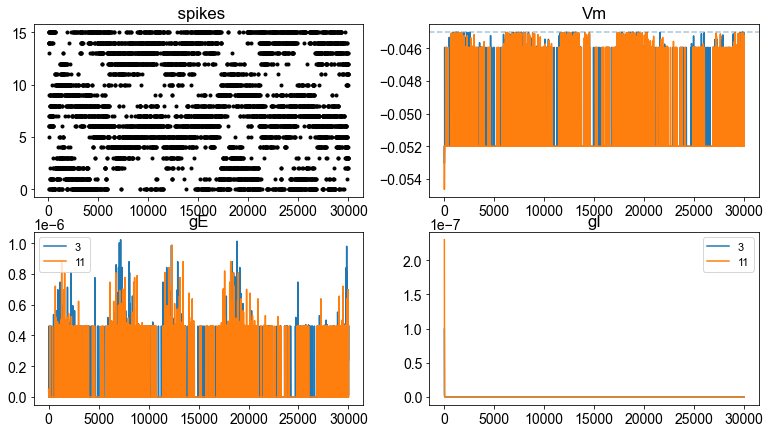

In [24]:
cx_spiking.plotting.plot_stuff(STM_TL2, SPM_TL2, observation_list=range(16), figsize=(13,7))
cx_spiking.plotting.plot_stuff(STM_TL2, SPM_TL2, observation_list=[3, 11], figsize=(13,7))